In [1]:
import os
from pathlib import Path
from boutdata import collect
from matplotlib import pyplot as plt
import numpy as np
from netCDF4 import Dataset
import glob
from scipy.ndimage import zoom

In [2]:

s1 = r"/Volumes/TOSHIBA EXT/Deep Learning/Data/Probe"
s2 = r"/Volumes/TOSHIBA EXT/Deep Learning/Data/Simulation"
e = r"data_numpy"

print(Path("/Volumes/TOSHIBA EXT/Deep Learning/Data/Probe").exists())


DATA_LOCATION_PROBE = Path(s1)
DATA_LOCATION_SIMULATION = Path(s2)
EXPORT_LOCATION = Path(e)

field_list = ['n'] # Extract density
probe_list = ['0', '1', '2', '3', '4', '5', '6'] # We need all 7 probes


True


In [4]:
probe_data = {}
for p in probe_list:
    probe_data[p] = {}

    probe_vars = [f"{f}{p}" for f in field_list]
    probe_vars.append('t_array')
    for var in probe_vars:
        for file in glob.glob(f'{DATA_LOCATION_PROBE}/BOUT.fast.*'):
            try:
                with Dataset(file) as f:
                    probe_data[p][var] = f[var][:]
                    print(f"data {var} loaded from {file.split('/')[-1]}")
                    break
            except:
                continue

print(probe_data)

data n0 loaded from BOUT.fast.12.nc
data t_array loaded from BOUT.fast.0.nc
data t_array loaded from BOUT.fast.0.nc
data n1 loaded from BOUT.fast.19.nc
data n1 loaded from BOUT.fast.19.nc
data t_array loaded from BOUT.fast.0.nc
data t_array loaded from BOUT.fast.0.nc
data n2 loaded from BOUT.fast.25.nc
data n2 loaded from BOUT.fast.25.nc
data t_array loaded from BOUT.fast.0.nc
data t_array loaded from BOUT.fast.0.nc
data n3 loaded from BOUT.fast.32.nc
data n3 loaded from BOUT.fast.32.nc
data t_array loaded from BOUT.fast.0.nc
data t_array loaded from BOUT.fast.0.nc
data n4 loaded from BOUT.fast.38.nc
data n4 loaded from BOUT.fast.38.nc
data t_array loaded from BOUT.fast.0.nc
data t_array loaded from BOUT.fast.0.nc
data n5 loaded from BOUT.fast.44.nc
data n5 loaded from BOUT.fast.44.nc
data t_array loaded from BOUT.fast.0.nc
data t_array loaded from BOUT.fast.0.nc
data n6 loaded from BOUT.fast.51.nc
data n6 loaded from BOUT.fast.51.nc
data t_array loaded from BOUT.fast.0.nc
{'0': {'n0':

In [5]:
# Parse BOUT.settings to discover number of probes
settings_file = Path("BOUT.settings")
probe_indices = set()

print(f"Looking for settings file at: {settings_file.resolve()}")

if settings_file.exists():
    with open(settings_file, 'r') as f:
        in_fast_output = False
        for line in f:
            if '[fast_output]' in line:
                in_fast_output = True
                continue
            if in_fast_output and line.startswith('['):
                break
            if in_fast_output and 'xpos' in line:
                # Extract probe index from 'xpos0', 'xpos1', etc.
                match = re.search(r'xpos(\d+)', line)
                if match:
                    idx = int(match.group(1))
                    value = line.split('=')[1].strip().split('#')[0].strip()
                    # Only include probes with valid positions (not -1)
                    if value != '-1':
                        probe_indices.add(str(idx))
    
    probe_indices = sorted(list(probe_indices))
    print(f"Probes from BOUT.settings [fast_output]:")
    print(f"  Active probes: {probe_indices}")
    print(f"  Total count: {len(probe_indices)}")
else:
    print(f"BOUT.settings not found at {settings_file.resolve()}")

Looking for settings file at: /Users/mathiesellehauge/Desktop/Universitet/MSc Computer sciences/Kurser MSc/Deep Learning/Project/02456_Deep_Learning/BOUT.settings


NameError: name 're' is not defined

In [6]:
nx, nz = collect('nx', path=DATA_LOCATION_SIMULATION), collect('nz', path=DATA_LOCATION_SIMULATION)

probe_pos = {}
for p in probe_list:
    probe_pos[p] = {}
    frac = 0.1*(int(p)+2)
    probe_pos[p]['x'] = round(frac*int(nx))
    probe_pos[p]['z'] = round(0.5*int(nz))

print(probe_pos)

{'0': {'x': 103, 'z': 256}, '1': {'x': 154, 'z': 256}, '2': {'x': 206, 'z': 256}, '3': {'x': 257, 'z': 256}, '4': {'x': 308, 'z': 256}, '5': {'x': 360, 'z': 256}, '6': {'x': 411, 'z': 256}}


In [ ]:
sim_data = {}
sim_data['t_array'] = collect('t_array', path = DATA_LOCATION_SIMULATION)
for f in field_list:
    sim_data[f] = collect(f, path = DATA_LOCATION_SIMULATION)

mxsub = 8 mysub = 1 mz = 512

nxpe = 64, nype = 1, npes = 64

mxsub = 8 mysub = 1 mz = 512

nxpe = 64, nype = 1, npes = 64

Reading from 0: [0-8][0-0] -> [0-8][0-0]

Reading from 1: [1-8][0-0] -> [9-16][0-0]

Reading from 1: [1-8][0-0] -> [9-16][0-0]

Reading from 2: [1-8][0-0] -> [17-24][0-0]

Reading from 2: [1-8][0-0] -> [17-24][0-0]

Reading from 3: [1-8][0-0] -> [25-32][0-0]

Reading from 3: [1-8][0-0] -> [25-32][0-0]

Reading from 4: [1-8][0-0] -> [33-40][0-0]

Reading from 4: [1-8][0-0] -> [33-40][0-0]

Reading from 5: [1-8][0-0] -> [41-48][0-0]

Reading from 5: [1-8][0-0] -> [41-48][0-0]

Reading from 6: [1-8][0-0] -> [49-56][0-0]

Reading from 6: [1-8][0-0] -> [49-56][0-0]

Reading from 7: [1-8][0-0] -> [57-64][0-0]

Reading from 7: [1-8][0-0] -> [57-64][0-0]

Reading from 8: [1-8][0-0] -> [65-72][0-0]

Reading from 8: [1-8][0-0] -> [65-72][0-0]

Reading from 9: [1-8][0-0] -> [73-80][0-0]

Reading from 9: [1-8][0-0] -> [73-80][0-0]

Reading from 10: [1-8][0-0] -> [81-88][0-0]


501


501


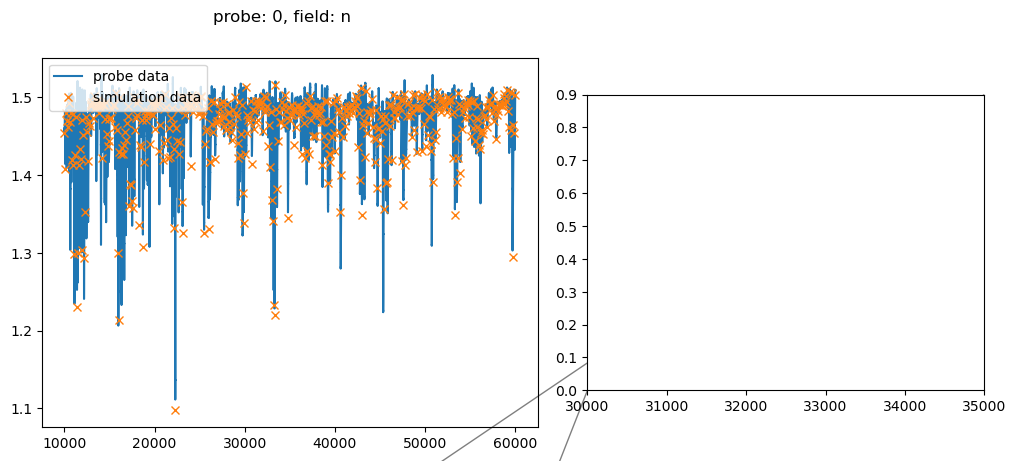

501


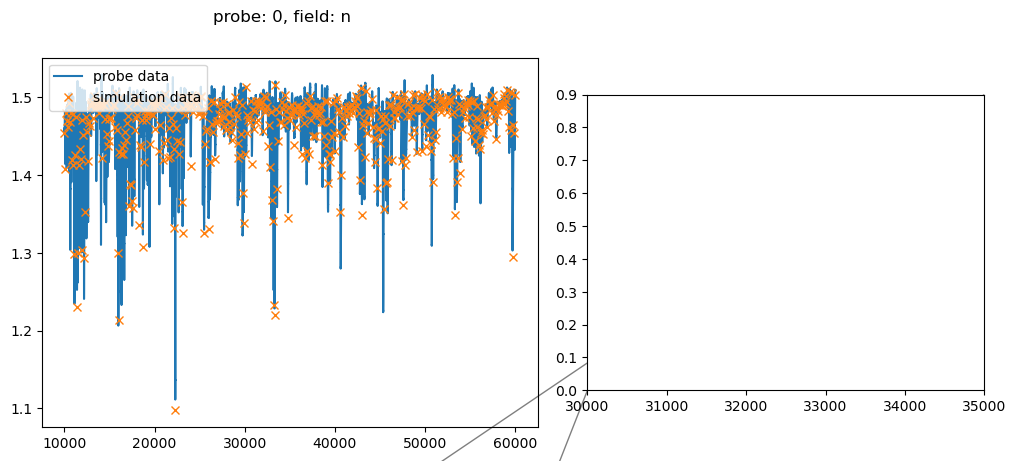

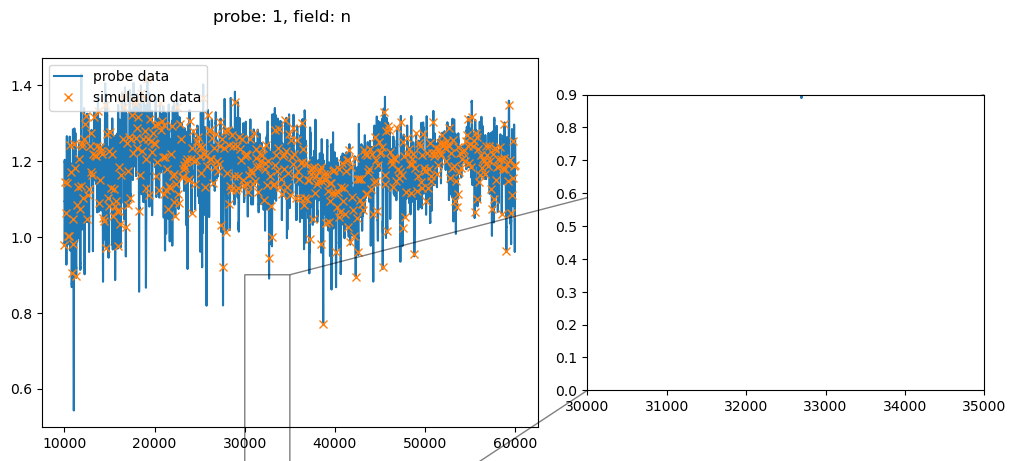

501


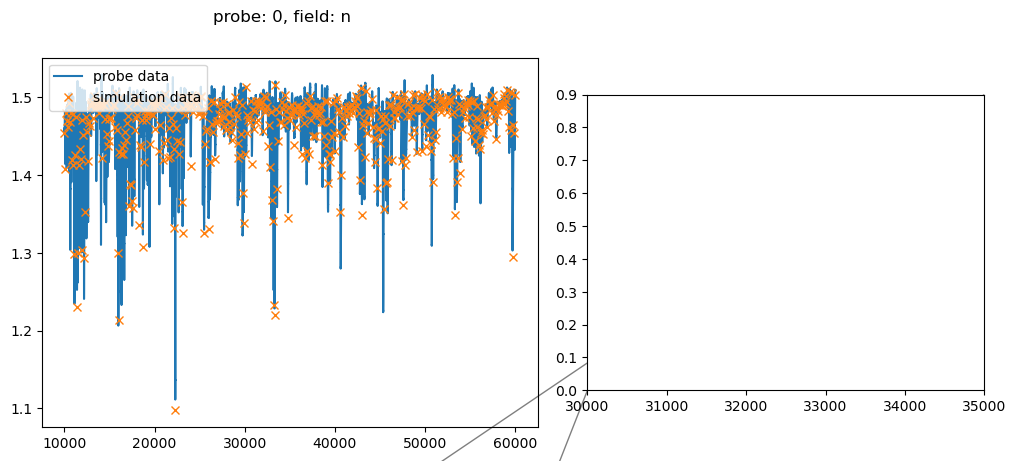

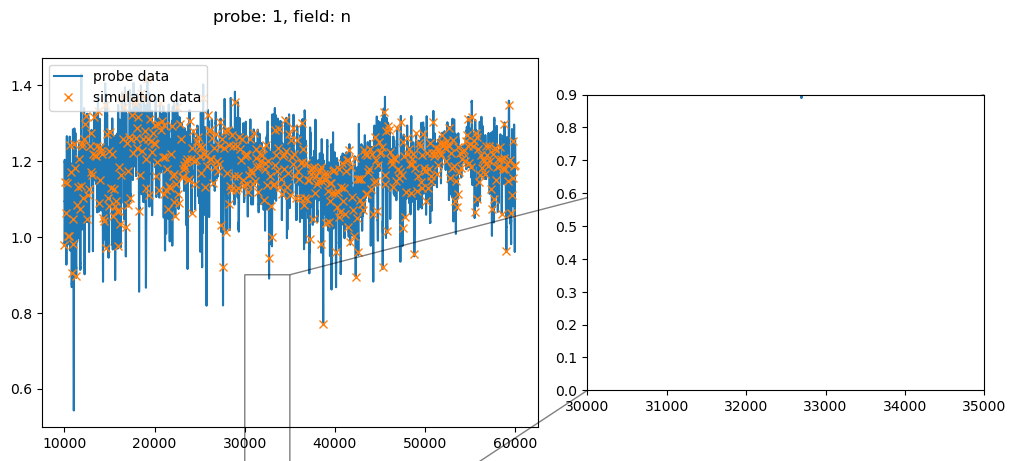

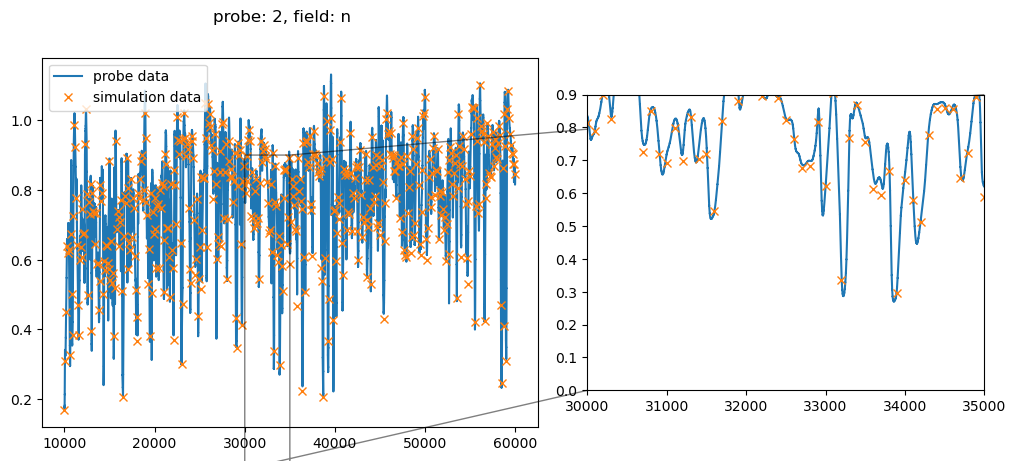

501


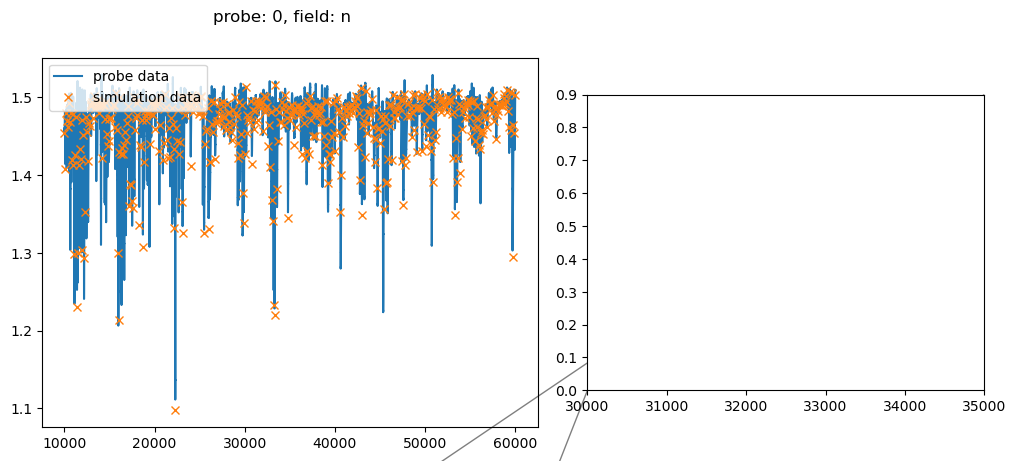

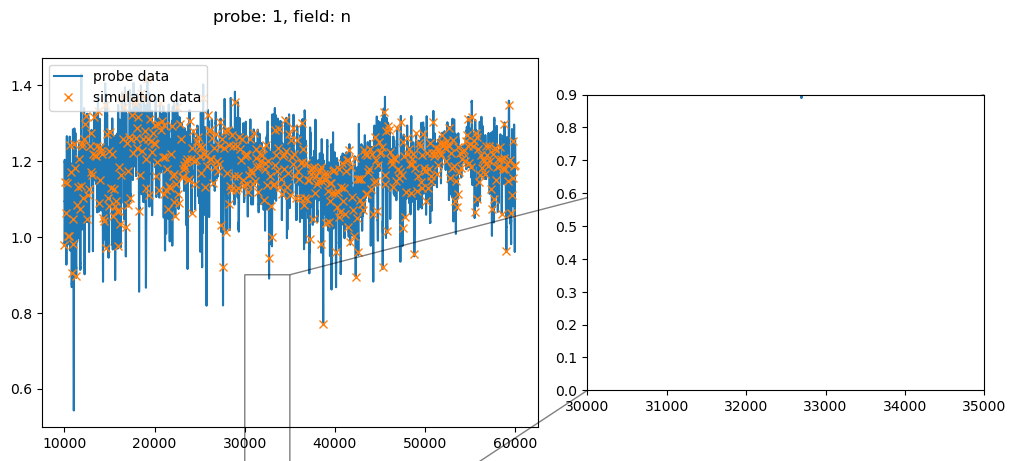

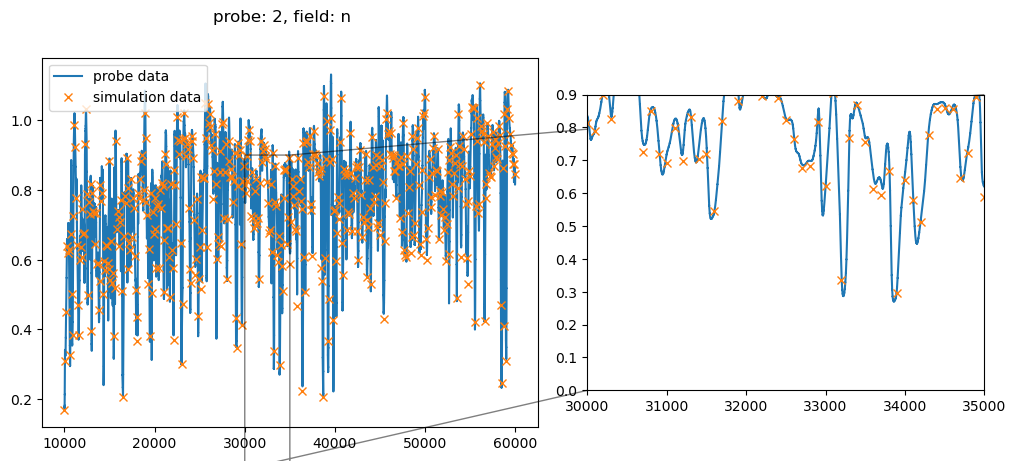

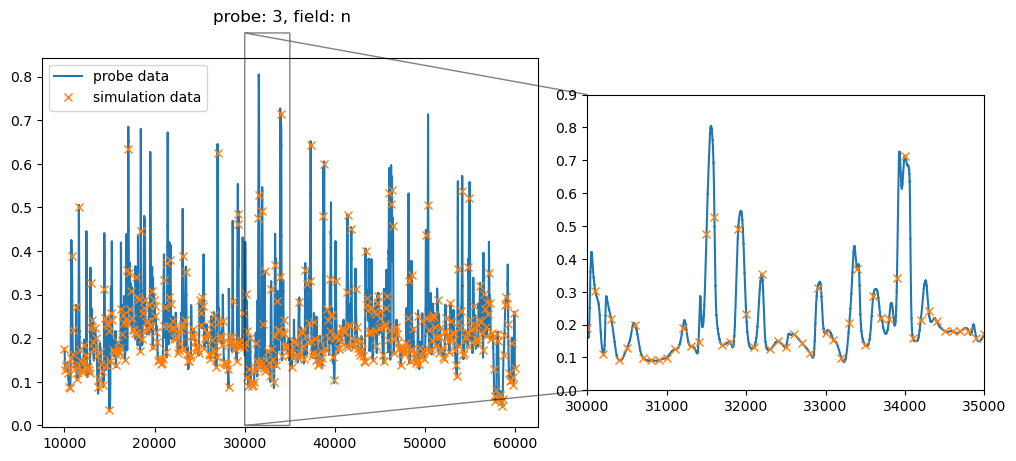

501


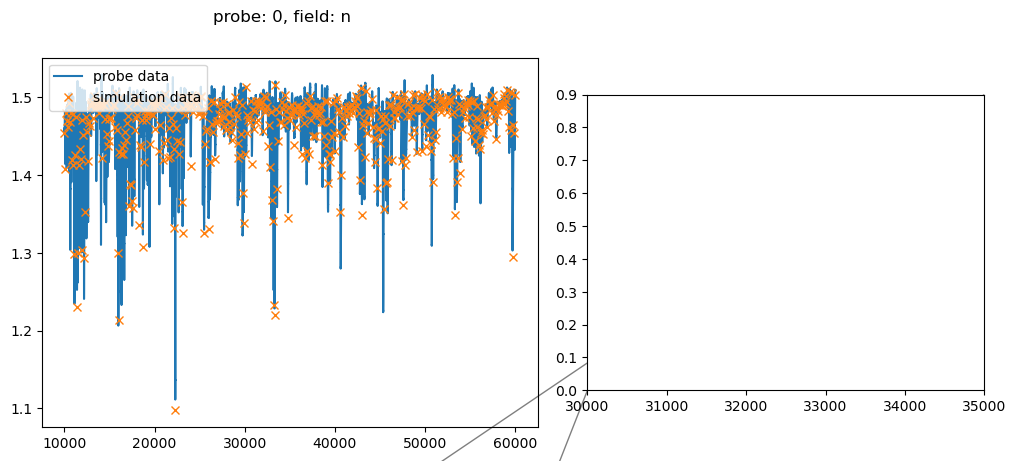

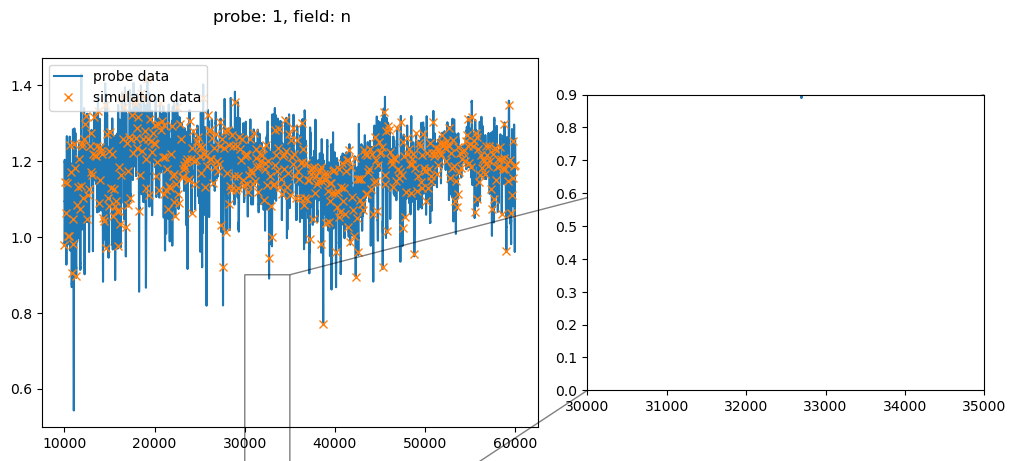

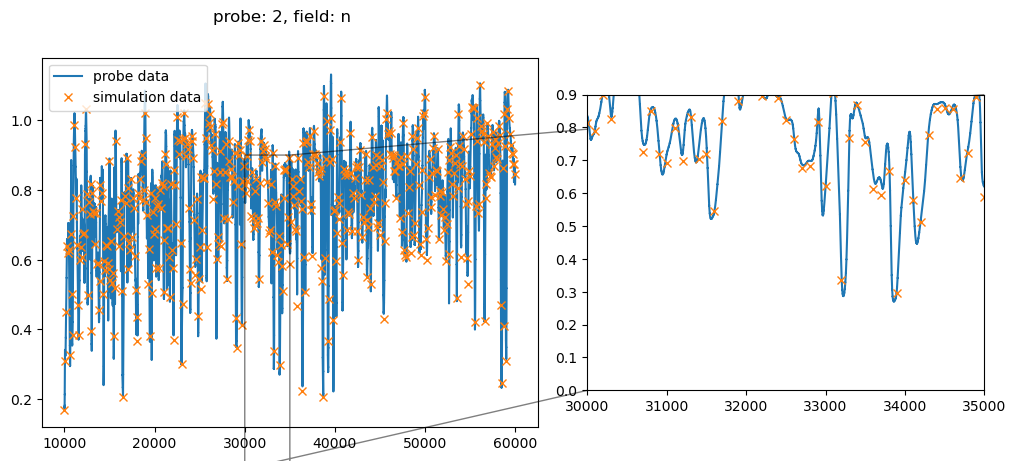

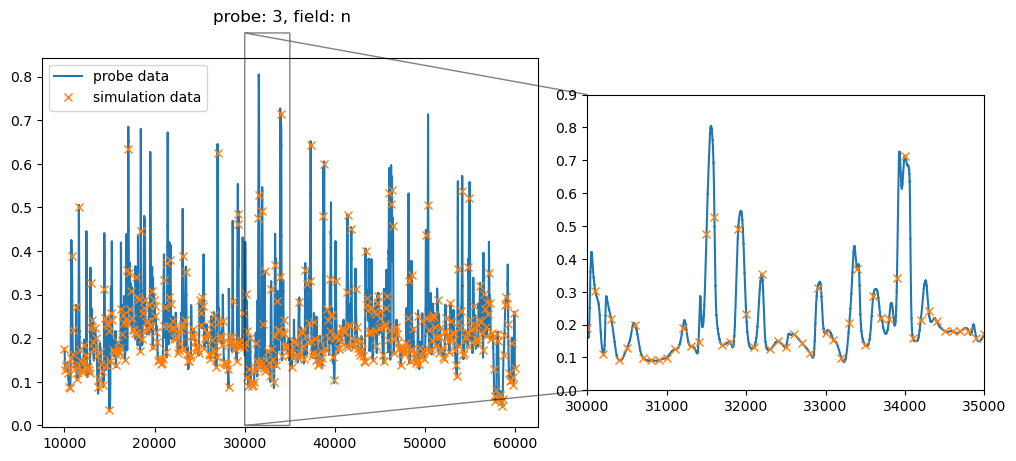

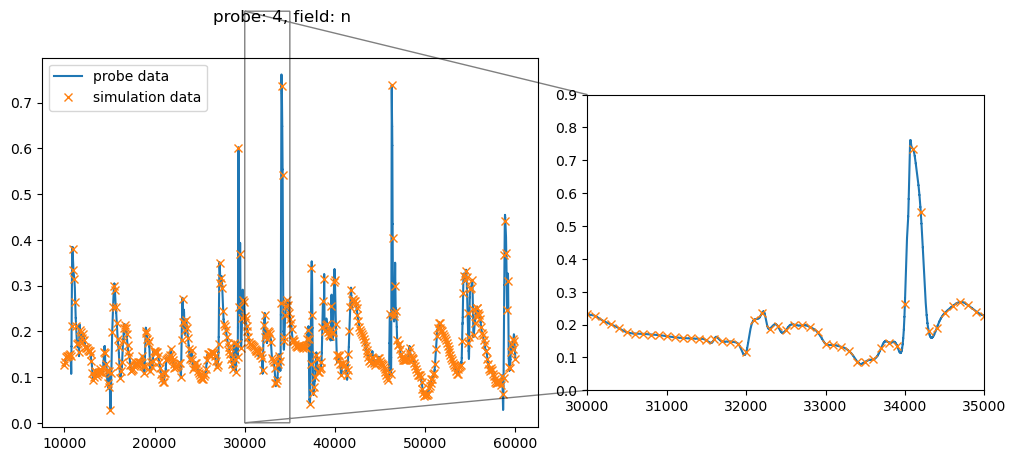

501


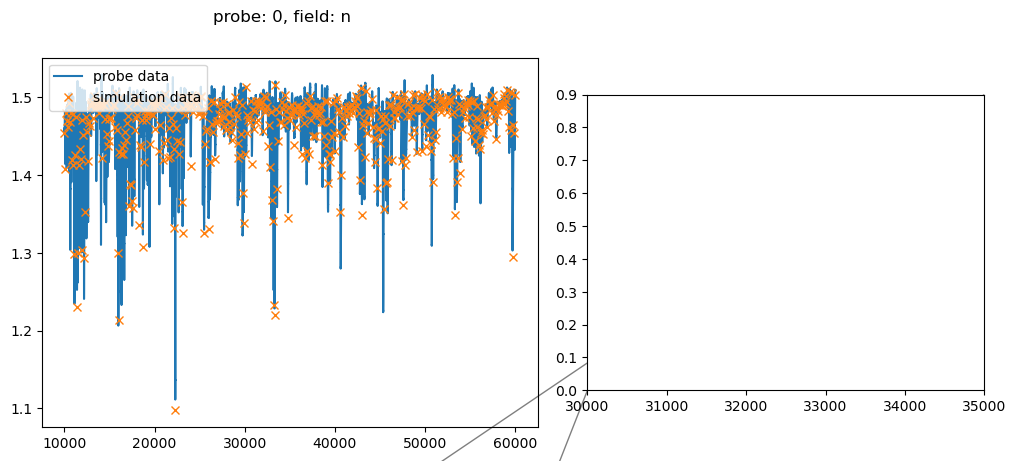

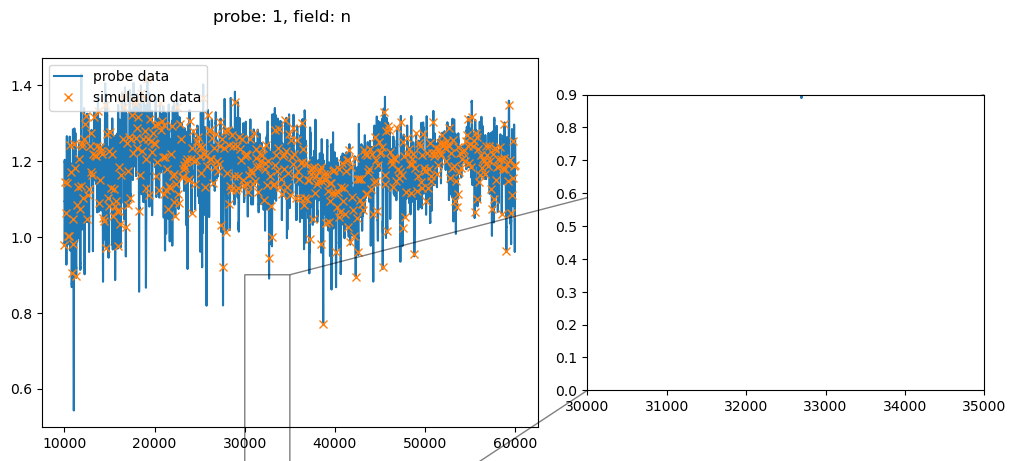

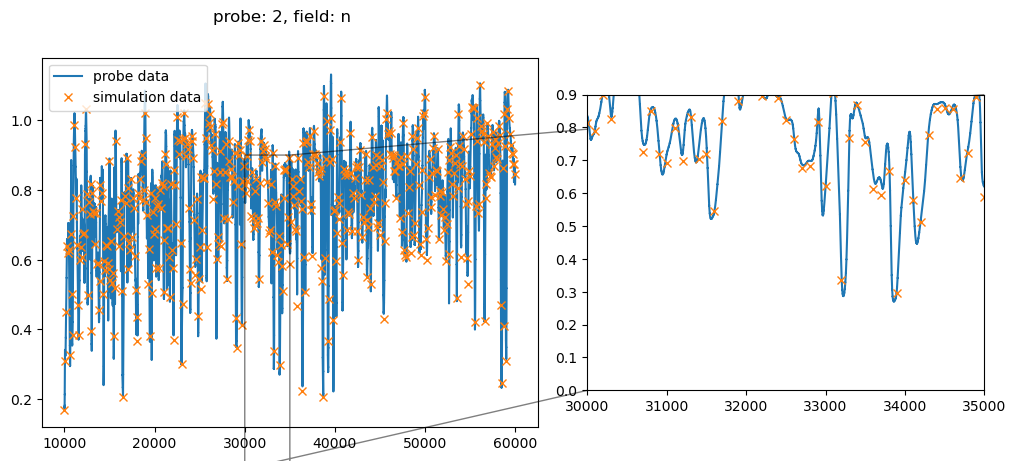

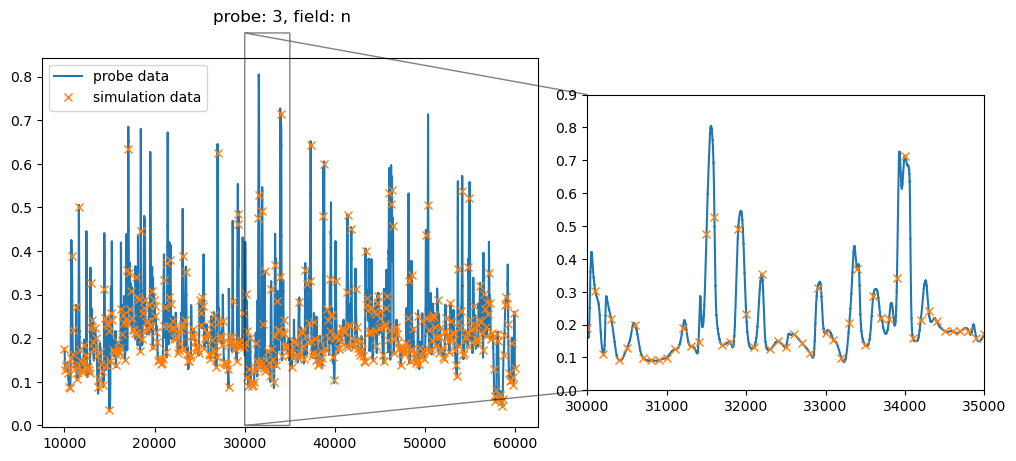

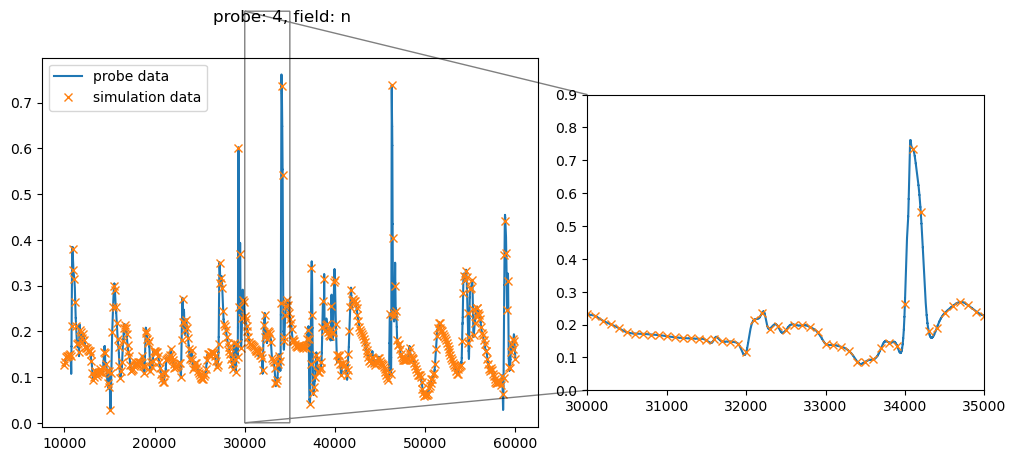

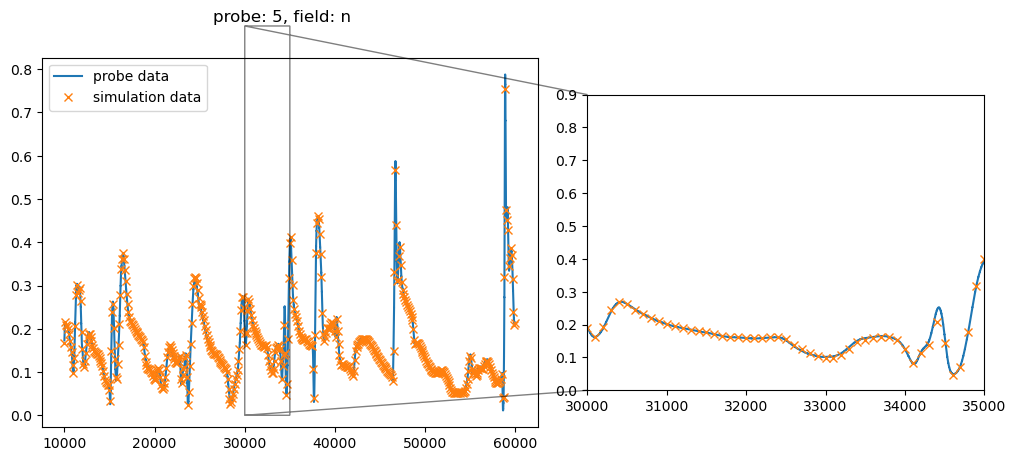

501


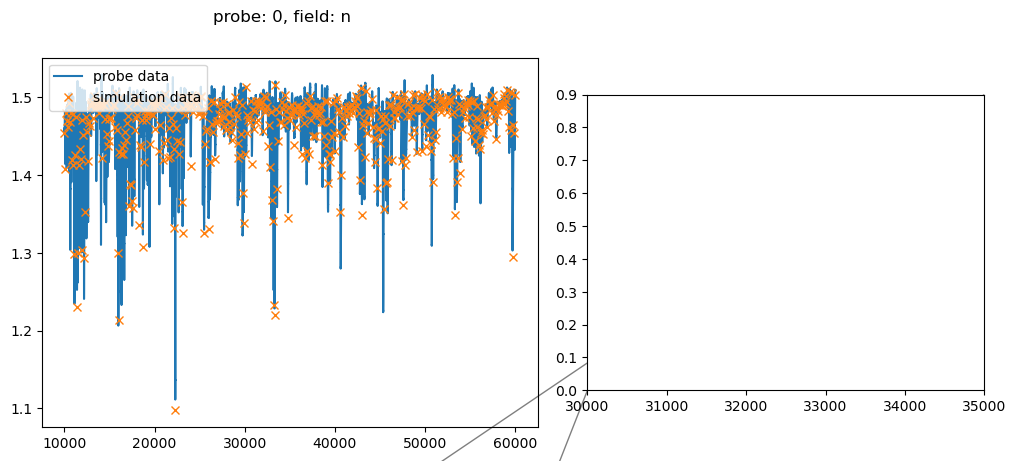

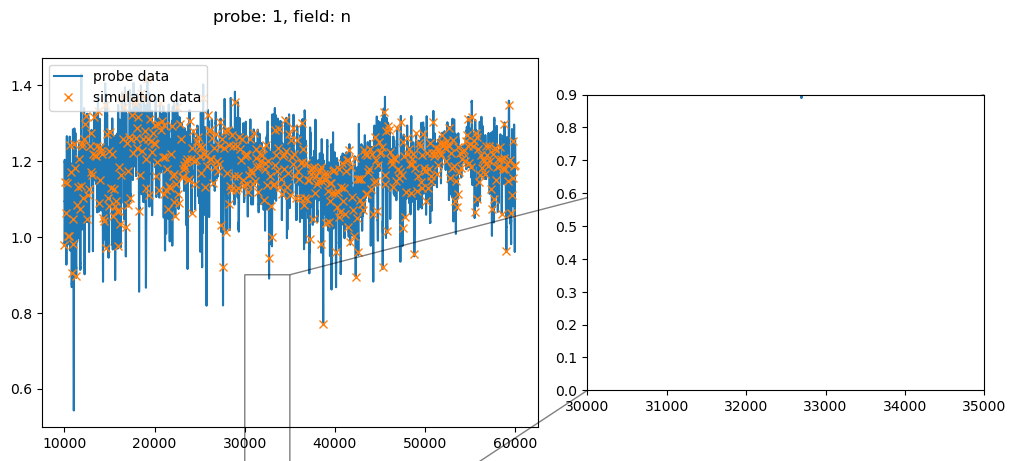

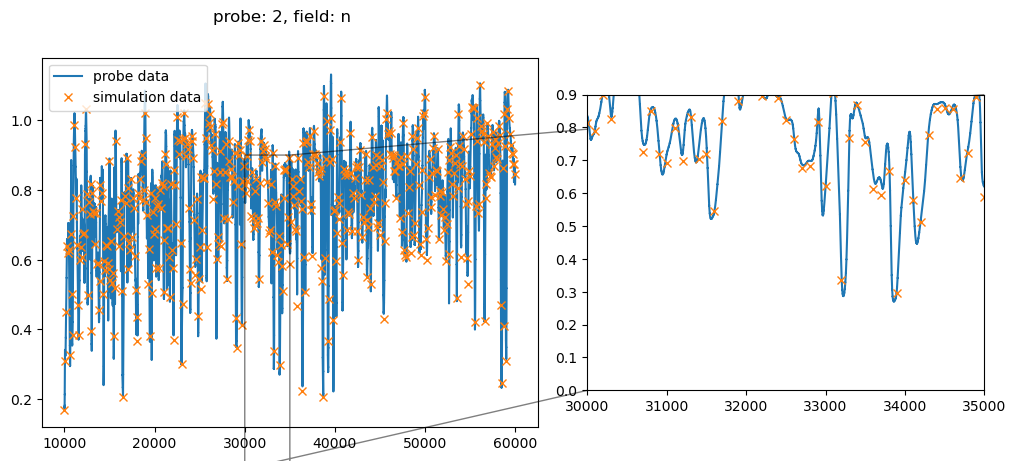

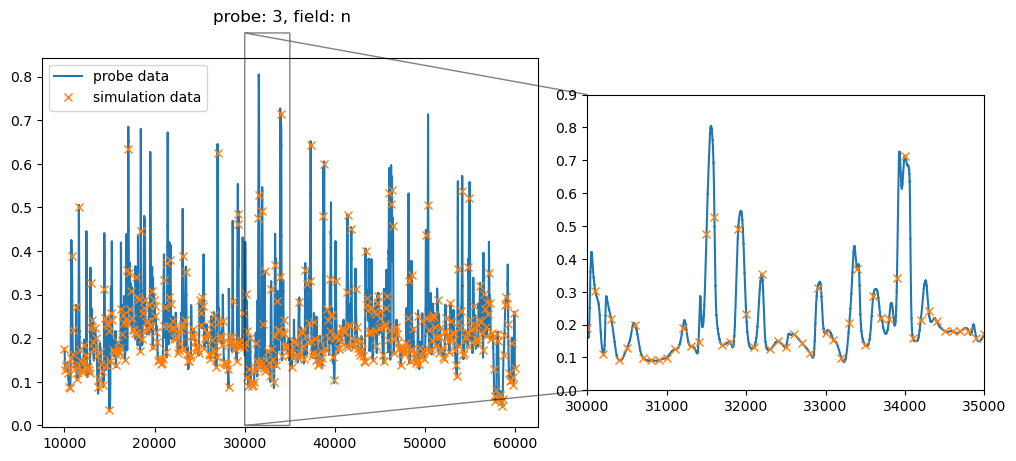

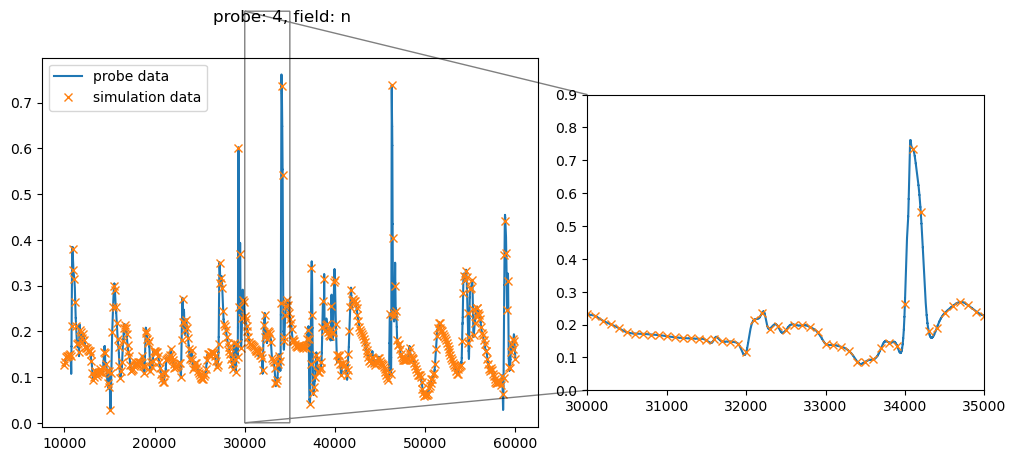

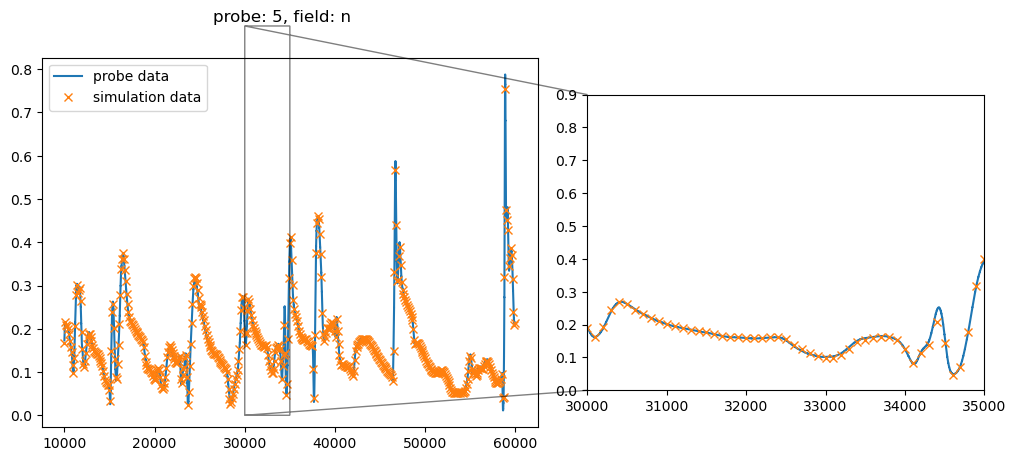

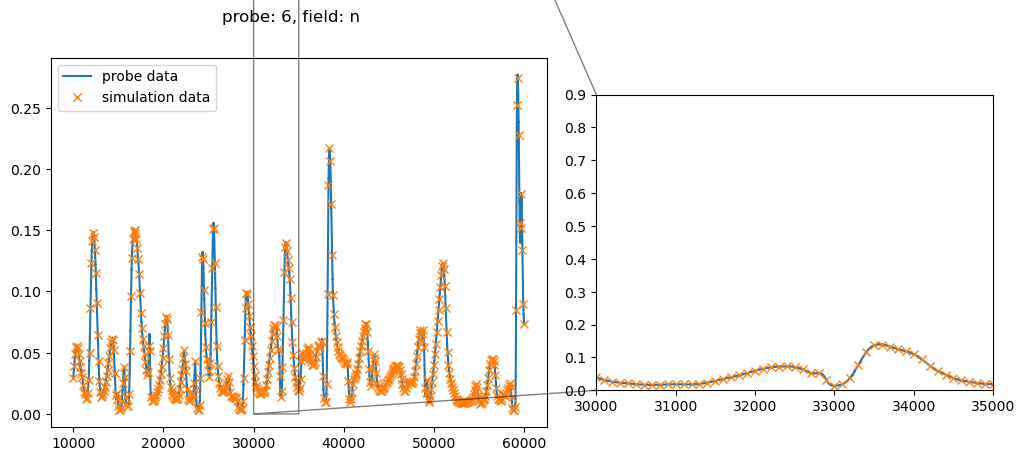

In [ ]:
zoom_t_start = 30000 
zoom_t_end = 35000
zoom_y_min = 0.0
zoom_y_max = 0.9

print(len(sim_data['t_array']))

for p in probe_list:
    for f in field_list:
        fig, ax = plt.subplots()
    
        ax.plot(probe_data[p]['t_array'], probe_data[p][f"{f}{p}"], label = 'probe data')
        ax.plot(sim_data['t_array'], sim_data[f][:, probe_pos[p]['x'], 0, probe_pos[p]['z']], "x", label = 'simulation data')
        ax.legend(loc="upper left")
    
        ax_inset = ax.inset_axes([1.1, 0.1, 0.8, 0.8])
    
        ax_inset.plot(probe_data[p]['t_array'], probe_data[p][f"{f}{p}"], label = 'probe data')
        ax_inset.plot(sim_data['t_array'], sim_data[f][:, probe_pos[p]['x'], 0, probe_pos[p]['z']], "x", label = 'simulation data')
    
        ax_inset.set_xlim(zoom_t_start, zoom_t_end)
        ax_inset.set_ylim(zoom_y_min, zoom_y_max)
        
        ax.indicate_inset_zoom(ax_inset, edgecolor="black")
    
        fig.suptitle(f"probe: {p}, field: {f}")

In [ ]:
# Create a dictionary to store probe data in a saveable format
probe_data_export = {}

for p in probe_list:
    position = probe_pos[p]  # a dictionary with x and z
    probe_measurement = probe_data[p]['n' + p]
    probe_data_export[f'probe_{p}'] = {
        'position': position,
        'measurement': probe_measurement
    }

# Save as numpy .npy file
EXPORT_LOCATION.mkdir(parents=True, exist_ok=True)
export_path = EXPORT_LOCATION / 'probe_data.npy'
np.save(export_path, probe_data_export)

print(f"Saved probe data to {export_path}")
print(f"Data contains {len(probe_data_export)} probes")
for p in probe_list:
    print(f"  probe_{p}: position={probe_data_export[f'probe_{p}']['position']}, measurement shape={probe_data_export[f'probe_{p}']['measurement'].shape}")

[0. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0.]


ValueError: setting an array element with a sequence.